In [1]:
%load_ext autoreload
%autoreload 2
# this only works on startup!
from jax import config
config.update("jax_enable_x64", True)

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '1'
from encoding_information.gpu_utils import limit_gpu_memory_growth
limit_gpu_memory_growth()

from cleanplots import *
from tqdm import tqdm
from encoding_information.information_estimation import *
from encoding_information.image_utils import *
from encoding_information.models.gaussian_process import StationaryGaussianProcess

from encoding_information.bsccm_utils import *
from bsccm import BSCCM
from jax import jit
import numpy as onp
import jax.numpy as np


2023-10-26 10:07:34.097171: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-26 10:07:36.533384: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cublas/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cuda_cupti/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cuda_nvcc/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cuda_nvrtc/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cuda_runtime/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/pyth

In [6]:
from encoding_information.bsccm_utils import *
from encoding_information.image_utils import *

bsccm = BSCCM('/home/hpinkard_waller/data/BSCCM/')

# load images, extract patches, and compute cov mats
edge_crop = 32
patch_size = 3
num_images = 1000

# channel = 'LED119'
channel = 'DPC_Right'

num_test_images = 500

all_images = load_bsccm_images(bsccm, channel=channel, num_images=num_images + num_test_images, edge_crop=edge_crop, median_filter=False)
images = all_images[:num_images]
test_images = all_images[num_images:]
test_patches = extract_patches(test_images, patch_size, num_patches=num_test_images, seed=0)

num_patches = 1000
seed = 10

patches = extract_patches(images, patch_size, num_patches=num_patches, seed=seed)


Opening BSCCM
Opened BSCCM


In [7]:
eigenvalue_floor = 1e-3

from encoding_information.models.pixel_cnn import PixelCNN

pixel_cnn = PixelCNN()

pixel_cnn.fit(patches, max_epochs=5, num_val_samples=100)

Initial validation NLL: 295.82


Epoch 1: 100%|██████████| 100/100 [00:32<00:00,  3.08it/s]


Epoch 1: validation NLL: 6.53


Epoch 2: 100%|██████████| 100/100 [00:04<00:00, 22.69it/s]


Epoch 2: validation NLL: 6.50


Epoch 3: 100%|██████████| 100/100 [00:04<00:00, 22.27it/s]


Epoch 3: validation NLL: 5.77


Epoch 4: 100%|██████████| 100/100 [00:04<00:00, 22.81it/s]


Epoch 4: validation NLL: 5.44


Epoch 5: 100%|██████████| 100/100 [00:04<00:00, 23.30it/s]


Epoch 5: validation NLL: 5.42


[295.8239440917969,
 6.531512260437012,
 6.50245475769043,
 5.772763252258301,
 5.4368896484375,
 5.4164252281188965]

Generating PixelCNN samples:  20%|██        | 1/5 [00:06<00:26,  6.54s/it]2023-10-26 10:25:23.281847: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:808] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.
2023-10-26 10:25:23.282067: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:811] Conv: (f64[128,3,2,4]{3,2,1,0}, u8[0]{0}) custom-call(f64[128,64,3,3]{3,2,1,0}, f64[3,64,2,4]{3,2,1,0}), window={size=2x4 pad=0_0x2_2 rhs_reversal=1x1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}
Generating PixelCNN samples:  40%|████      | 2/5 [00:22<00:36, 12.07s/it]2023-10-26 10:25:46.692657: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:808] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.
2023-10-26 10:25:46.699903: W external/xla/xla/service/gpu/conv_algorithm_picker

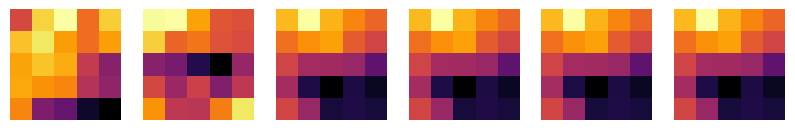

In [9]:
samples = pixel_cnn.generate_samples(3, 5)

fig, axs = plt.subplots(1, 6, figsize=(10, 10))
for k in range(6):
    axs[k].imshow(samples[k], cmap='inferno')
    axs[k].axis('off')
    